# 检验趋势策略的趋势性

参考文献：https://mp.weixin.qq.com/s/Mhu2SB6AMzga_Y1pvwM6PQ

In [1]:
import sys
sys.path.append('C:\\Users\\xpy\\work\\strategies2py\\AprilQuant')
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import empyrical

from backtest.indicators import ATR, AllNaError
from backtest.return_rate_calculations import (
    cal_avg_cum_ret, 
    avg_cum_ret_from_cursor, 
    cal_ret, 
    cum_ret_from_doc
)
from backtest.check_for_momentum import (
    get_cum_ret_dict,
    cal_strategy_overall_tendency,
    ATR_position_sizing
)
from utils import query, plot_curves
from consts import C_DAILY

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

cum_ret_dict = get_cum_ret_dict('C73', 'daily', length=60, ema_length=150, trs=0.12, lqk_width=0.1, lqk_floor=0.5)

## 1.检验假设：策略在所有品种上具有相同周期的动量效应
检验方法与参考文献相同。  
可以发现，对于任何长度的历史期和预测期，历史期与预测期收益率相关系数显著为负的比例明显高于相关系数显著为正的比例，证明策略在所有品种相同周期上有具有更强的反转效应而非动量效应。假设不能成立。

In [2]:
hist_len_rng = (240, 480, 720, 960, 1200)
pred_len_rng = (20, 60, 120, 240)

params = [
    (hist_len, pred_len) 
    for pred_len in pred_len_rng 
    for hist_len in hist_len_rng
]
lines = []
for param in params:
    line = cal_strategy_overall_tendency(cum_ret_dict, hist_len=param[0], pred_len=param[1])
    lines.append(line)
summary = pd.DataFrame(lines).sort_values('hist_len')
display(summary)

,hist_len,pred_len,category_num,sig_pos_related,sig_neg_related,successful_prediction
0,240,20,47,0.042553,0.744681,0.021277
5,240,60,46,0.173913,0.717391,0.239130
10,240,120,45,0.177778,0.711111,0.400000
15,240,240,42,0.142857,0.809524,0.404762
1,480,20,41,0.048780,0.707317,0.048780
6,480,60,41,0.073171,0.756098,0.243902
11,480,120,39,0.153846,0.666667,0.410256
16,480,240,37,0.189189,0.756757,0.405405
2,720,20,36,0.055556,0.833333,0.138889
17,720,240,33,0.060606,0.787879,0.303030


## 2. 多品种策略表现
由于动量效应不明显，不考虑动态筛选品种。  
使用固定比例法调整各品种仓位。调整仓位后，策略收益率与Sharpe比率均有所提升，且对参数不敏感。

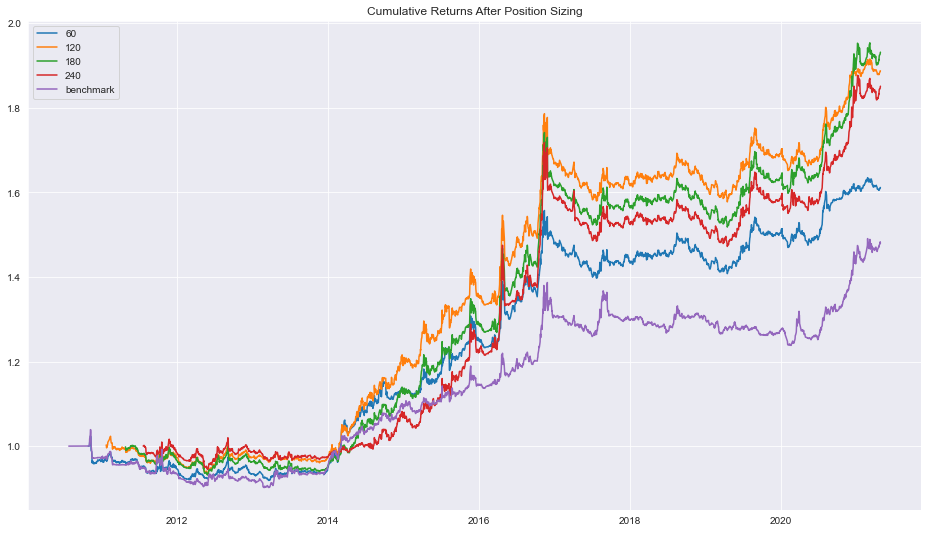

In [3]:
atr_length_rng = (60, 120, 180, 240)

weighted_cum_rets = [
    ATR_position_sizing(cum_ret_dict, 'daily', atr_length, atr_length) 
    for atr_length in atr_length_rng
]
benchmark = cal_avg_cum_ret(cum_ret_dict.values())

plot_curves([*weighted_cum_rets, benchmark], 'Cumulative Returns After Position Sizing', [*atr_length_rng, 'benchmark'])

In [4]:
for atr_length, cum_ret in zip([*atr_length_rng, None], weighted_cum_rets + [benchmark]):
    sr = empyrical.sharpe_ratio(cal_ret(cum_ret))[0]
    output_string = f'使用 {atr_length} 期ATR调整仓位: ' if atr_length is not None \
                else '不调整仓位：            '
          
    output_string += f'累计收益率为 {cum_ret.cum_ret.tolist()[-1]} '
    output_string += f'Sharpe Ratio 为 {sr}'
    print(output_string)

使用 60 期ATR调整仓位: 累计收益率为 1.6112439453354037 Sharpe Ratio 为 0.7394508487268946
使用 120 期ATR调整仓位: 累计收益率为 1.8873130115214443 Sharpe Ratio 为 0.9171589714226405
使用 180 期ATR调整仓位: 累计收益率为 1.9316350226123986 Sharpe Ratio 为 0.9392920718207182
使用 240 期ATR调整仓位: 累计收益率为 1.8511713487819619 Sharpe Ratio 为 0.7762126566609926
不调整仓位：            累计收益率为 1.4796587366607221 Sharpe Ratio 为 0.6567311875733329
